# MODNet 'matbench_jdft2d' benchmarking

Matbench v0.1 test dataset for predicting exfoliation energies from crystal structure (computed with the OptB88vdW and TBmBJ functionals). Adapted from the JARVIS DFT database. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset, get_all_dataset_info
from IPython.display import Markdown
from modnet.preprocessing import MODData
from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [3]:
Markdown(filename="./README.md")

# matbench_jdft2d

## Introduction

- 636 2D structures and their exfoliation energies

Results to beat:

| Method | Exfoliation energy (meV) |
|:-------|-------------------------:|
| AM     | 38.6                     |
| RF     | 49.9                     |
| CGCNN  | 49.2                     |
| MEGNet | 55.9                     |
| Dummy  | 67.3                     |

## Notes

- Another long-tailed dataset: dummy predictor does very well
- Trying MSE instead of MAE to capture tails

## To-do

- [x] Featurize
- [x] Feature selection 
- [x] Baseline models
- [ ] Feature importance

## Results

| Method | Exfoliation energy (meV) |
|:-------|-----------------:|
| Rough MODNet baseline | 32.7 |


## Data exploration

In [2]:
df = load_dataset("matbench_jdft2d")

In [3]:
df.columns

Index(['structure', 'exfoliation_en'], dtype='object')

### Target space

In [4]:
df.describe()

,exfoliation_en
count,636.000000
mean,112.698309
std,134.276663
min,0.026500
25%,58.811481
50%,79.803667
75%,101.289264
max,1604.038286


Text(0.5, 0, 'Exfoliation energy (meV)')

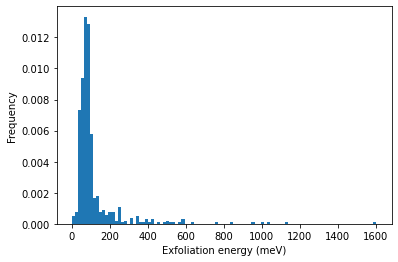

In [5]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["exfoliation_en"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("Exfoliation energy (meV)")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [3]:
PRECOMPUTED_MODDATA = "./precomputed/matbench_jdft2d.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_jdft2d")
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["exfoliation_en"].tolist(), 
        target_names=["Exfoliation energy (meV)"],
        featurizer=DeBreuck2020Featurizer(n_jobs=8)
    )
    data.featurize()
    data.feature_selection(n=650)
    data.save(PRECOMPUTED_MODDATA)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7f3f3fb199d0> object, created with modnet version 0.1.8~develop


In [134]:
try:
    plot_benchmark
except:
    os.chdir("..")
    from modnet_matbench.utils import *
from sklearn.model_selection import KFold
from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

data.df_targets.rename(columns={data.target_names[0]: "E"}, inplace=True)

best_settings = {
    "num_neurons": [[64], [32], [8], [8]],
    "n_feat": 256,
    "lr": 0.005,
    "epochs": 1000,
    "act": "elu",
    "batch_size": 32,
    "loss": "mae",
}    

results = matbench_benchmark(data, [[["E"]]], {"E": 1}, best_settings)

INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #1: MAE = 22.017333843480017


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #2: MAE = 25.57527347057119


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #3: MAE = 47.64422752278413


INFO:root:Compiling model...
INFO:root:Fitting model...


Model #4: MAE = 27.49727212490035
Model #5: MAE = 40.79809928099567
Overall MAE = 32.70644124854627


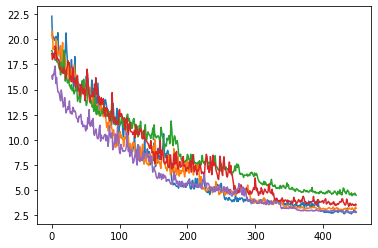

In [133]:
for i in range(5):
    plt.plot(results["models"][i].history.history["loss"][50:])

In [124]:
import seaborn as sns
reg_df = pd.DataFrame(
    np.array([
        [x for targ in results["targets"] for x in targ],
        [y for pred in results["predictions"] for y in pred],
        [e for err in results["errors"] for e in err]
    ]).T,
    columns=["targets", "predictions", "errors"]
)
splits = []
for i in range(5):
    for j in range(len(results["targets"][i])):
        splits.append(i)
reg_df["split"] = splits

Text(0, 0.5, 'Pred.')

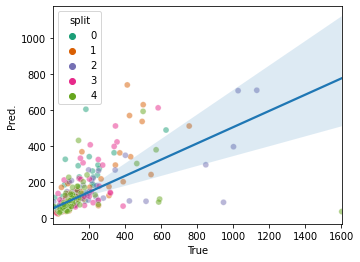

In [126]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
sns.scatterplot(data=reg_df, x="targets", y="predictions", hue="split", palette="Dark2", ax=ax, alpha=0.5)
sns.regplot(data=reg_df, x="targets", y="predictions", ax=ax, scatter=False)
plt.xlabel("True")
plt.ylabel("Pred.")

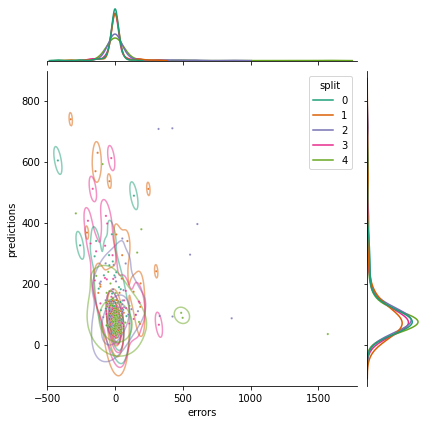

In [129]:
g = sns.jointplot(data=reg_df, x="errors", y="predictions", hue="split", palette="Dark2", alpha=0.0, marginal_kws={"shade": False})
g.plot_joint(sns.scatterplot, hue=None, c="black", s=5, alpha=0.8)
g.plot_joint(sns.kdeplot, color="split", zorder=0, levels=5, alpha=0.5)

<AxesSubplot:xlabel='targets', ylabel='predictions'>

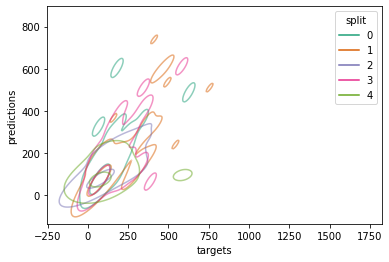

In [131]:
sns.kdeplot(data=reg_df, x="targets", y="predictions", hue="split", shade=False, levels=3, palette="Dark2", alpha=0.5, )